In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import random


class MnistDataSet(torch.utils.data.Dataset):
    def __init__(self):
        dataset1 = datasets.MNIST(root='./mnist_data/',
                               train=True,
                               download=True)

        self.data = dataset1.data.reshape(-1, 1, 28, 28).float() / 255.0

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

dataset = MnistDataSet()

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
        print('and then re-execute this cell.')
    else:
        print(gpu_info)
print('device :',device)
print('torch.version :',torch.__version__)

Sat Dec 19 06:03:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    22W / 300W |     10MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [48]:
def rp(mu, lv):
    return mu + torch.exp(0.5 * lv) * torch.randn_like(mu).to(device)

def KLD_normal(mu1, lv1, mu2, lv2):
    kld = lv2 - lv1 + (torch.exp(lv1) + ((mu1 - mu2)**2))/torch.exp(lv2) - 1.0
    return 0.5 * kld.sum(axis=1)

def RATE_normal(mu, lv):
    kld = - lv + torch.exp(lv) + (mu**2) - 1.0
    return 0.5 * kld.sum(axis=1)

def log_likelihood_normal(x, mu, lv):
    nllh2 = np.log(2.0 * np.pi) + lv + ((x - mu)**2)/torch.exp(lv)
    return -0.5 * nllh2.sum(axis=1) 

def precision_weighted_combination(mu1, lv1, mu2, lv2):
    precision1 = 1 / (torch.exp(lv1) + 1e-10)
    precision2 = 1 / (torch.exp(lv2) + 1e-10)
    mu = (precision1 * mu1 + precision2 * mu2) / (precision1 + precision2)
    lv = - torch.log(precision1 + precision2)
    return mu, lv


class EncoderMLPBlock(nn.Module):
    def __init__(self, in_features, out_features, z_dim):
        super(EncoderMLPBlock, self).__init__()
        self.base = nn.Sequential( # 32x32
            nn.Linear(in_features, out_features),
            nn.BatchNorm1d(out_features),
            nn.LeakyReLU()
        )
        self.inference = nn.Linear(out_features, 2 * z_dim)
        self.z_dim = z_dim


    def forward(self, d):
        d = self.base(d)
        params = self.inference(d)
        return d, params[:, :self.z_dim], params[:, self.z_dim:]


class DecoderMLPBlock(nn.Module):
    def __init__(self, in_features, hidden_features, z_dim):
        super(DecoderMLPBlock, self).__init__()
        self.base = nn.Sequential( # 32x32
            nn.Linear(in_features, hidden_features),
            nn.BatchNorm1d(hidden_features),
            nn.LeakyReLU(),
            nn.Linear(hidden_features, 2 * z_dim)
        )
        self.z_dim = z_dim

    def forward(self, z):
        params = self.base(z)
        return params[:, :self.z_dim], params[:, self.z_dim:]



class BottomUp(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Flatten(start_dim=1, end_dim=-1)
        )
        self.block = nn.ModuleList([
            EncoderMLPBlock(64 * 7 * 7, 512, 64),
            EncoderMLPBlock(512, 256, 32),               
            EncoderMLPBlock(256, 128, 16),               
            EncoderMLPBlock(128, 64,  8),               
            EncoderMLPBlock(64,  32,  4),               
        ])

        self.z_dims = [64, 32, 16, 8, 4]


    def forward(self, x):
        z_params = {}
        x = self.conv(x)
        for i, block_i in enumerate(self.block):
            x, mu_of_zi, lv_of_zi = block_i(x) 
            z_params[i] = {'mu':mu_of_zi, 'lv':lv_of_zi}
        return z_params


class View(nn.Module):
    def __init__(self, size):
        super(View, self).__init__()
        self.size = size

    def forward(self, tensor):
        return tensor.view(self.size)


class TopDown(nn.Module):
    def __init__(self):
        super().__init__()
        self.block = nn.ModuleList([
            DecoderMLPBlock(32, 256, 64),
            DecoderMLPBlock(16, 128, 32),
            DecoderMLPBlock(8, 64, 16),
            DecoderMLPBlock(4, 32, 8)
        ])

        self.convT = nn.Sequential(
            nn.Linear(64, 64 * 4),
            nn.BatchNorm1d(64 * 4),
            nn.LeakyReLU(),
            View((-1, 64, 2, 2)),
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=(2, 2), stride=(2, 2), padding=(0, 0)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=(2, 2), stride=(2, 2), padding=(0, 0)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=(2, 2), stride=(2, 2), padding=(0, 0)),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=16, out_channels=1, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0)),

            nn.Sigmoid()
        )
        self.top_level = 4

    def forward(self, z_bu):
        z_p_params = {}
        z_q_params = {}
        mu_z_top = z_bu[self.top_level]['mu']
        lv_z_top = z_bu[self.top_level]['lv']
        z_q_params[4] = {'mu':mu_z_top, 'lv':lv_z_top}
        z = rp(mu_z_top, lv_z_top)
        for i in [3, 2, 1, 0]:
            mu_p, lv_p = self.block[i](z)
            mu_q, lv_q = precision_weighted_combination(mu_p, lv_p, z_bu[i]['mu'], z_bu[i]['lv'])
            z = rp(mu_q, lv_q)
            z_q_params[i] = {'mu':mu_q, 'lv':lv_q}
            z_p_params[i] = {'mu':mu_p, 'lv':lv_p}
        return z_q_params, z_p_params, self.convT(z).reshape(-1, 1, 28, 28)

In [51]:
td = TopDown().to(device)
bu = BottomUp().to(device)
solver = optim.Adam(list(td.parameters()) + list(bu.parameters()), lr=1e-4)
mbsz = 1024
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=mbsz, shuffle=True, drop_last=True)

In [52]:
num_epochs = 400
beta = 0.0
KLD = [[], [], [], [], []]
NLL = []
for epoch in range(num_epochs):
    for x_q in loader:
        if beta < 1.0:
            beta += 1.0 / (len(loader) * 200)
        solver.zero_grad()
        x_q = x_q.to(device)

        z_q, z_p, x_p = td(bu(x_q))
        kld = RATE_normal(z_q[4]['mu'], z_q[4]['lv']).mean()
        KLD[4].append(kld.item()/bu.z_dims[4])
        kld_sum = kld
        for i in range(4):
            kld = KLD_normal(z_q[i]['mu'], z_q[i]['lv'], z_p[i]['mu'], z_p[i]['lv']).mean()
            KLD[i].append(kld.item()/bu.z_dims[i])
            kld_sum += kld

        recon = F.binary_cross_entropy(x_p, x_q, reduction='mean') * 784.
        NLL.append(recon.item() / 784.)
        loss = beta * kld_sum + recon
        loss.backward()
        solver.step()
    if epoch % 40 == 39:
        print(epoch, beta , NLL[-1], KLD[4][-1])




39 0.20000000000000565 0.08530428944801798 0.04818093776702881
79 0.39999999999996416 0.0862532343183245 0.14049383997917175
119 0.5999999999999066 0.08982786840322066 0.19912686944007874
159 0.799999999999849 0.09247927763024155 0.23842944204807281
199 0.9999999999997915 0.09332293880229094 0.2712627053260803
239 1.0000862068963432 0.09205898946645308 0.30663877725601196
279 1.0000862068963432 0.09099631406822983 0.3273746371269226
319 1.0000862068963432 0.09303707979163345 0.3505364656448364
359 1.0000862068963432 0.09257118069395727 0.36755242943763733
399 1.0000862068963432 0.09005204025579959 0.38771378993988037


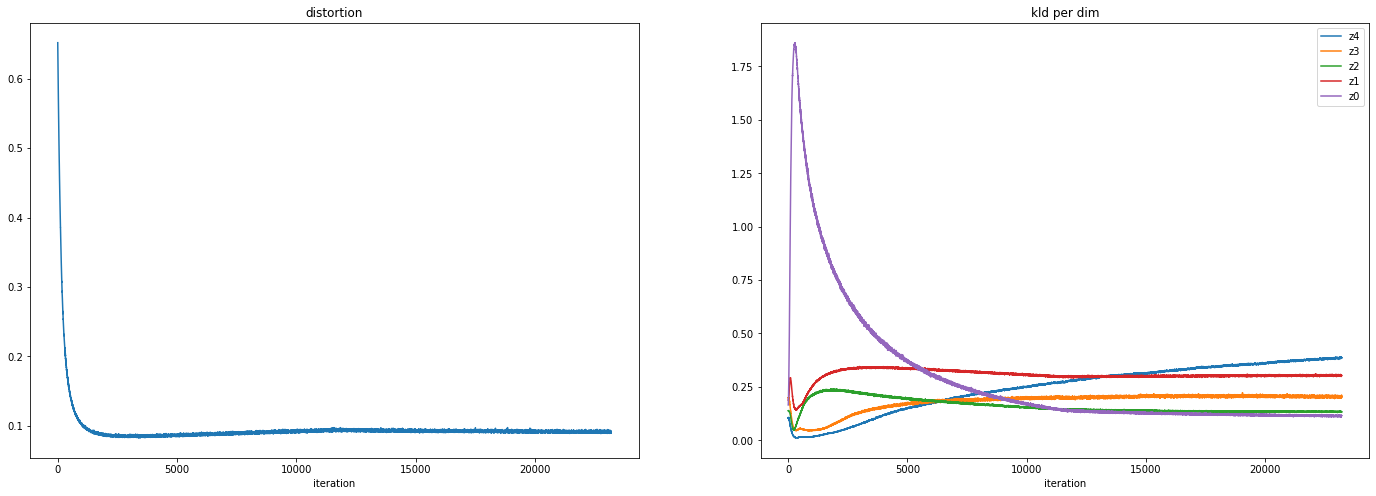

In [53]:

f = plt.figure(figsize=(24,8))
ax = f.add_subplot(1,2,1)
ax.plot(range(1, len(NLL) + 1), NLL)
ax.set_title('distortion')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(range(1, len(KLD[4]) + 1), KLD[4], label='z4')
ax.plot(range(1, len(KLD[3]) + 1), KLD[3], label='z3')
ax.plot(range(1, len(KLD[2]) + 1), KLD[2], label='z2')
ax.plot(range(1, len(KLD[1]) + 1), KLD[1], label='z1')
ax.plot(range(1, len(KLD[0]) + 1), KLD[0], label='z0')
ax.set_title('kld per dim')
ax.set_xlabel('iteration')
ax.legend()
plt.show()

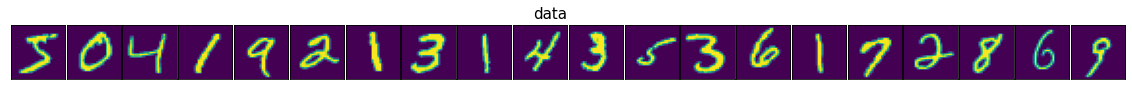

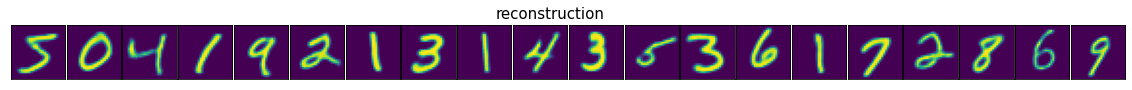

-


In [54]:
num_image = 20

fig = plt.figure(figsize=(20, 2))
n = 0
for i in range(num_image):
    _fig = fig.add_subplot(2, num_image, n + 1, xticks=[], yticks=[])
    _fig.imshow(dataset.data[n].cpu().reshape(28, 28).numpy())
    n += 1
fig.suptitle('data', y=1.01, fontsize=15)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

fig = plt.figure(figsize=(20, 2))
n = 0
td.eval()
bu.eval()
for i in range(num_image):

    x = dataset.data[n].reshape(1, 1, 28, 28).to(device)

    _a, _b, x_q = td(bu(x))

    _fig = fig.add_subplot(2, num_image, n + 1, xticks=[], yticks=[])
    _fig.imshow(x_q.cpu().data.numpy().reshape(28, 28))
    n += 1
fig.suptitle('reconstruction', y=1.01, fontsize=15)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()
td.train()
bu.train()
print('-')